In [1]:
import re

import networkx as nx

from IPython.display import Image, display
from collections import defaultdict, Counter
from textblob import TextBlob
from itertools import combinations
from tqdm import tqdm

from litecoder.db import City

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [3]:
def tokenize(text):
    return [str(t) for t in TextBlob(text).tokens]

In [11]:
class Token:
    
    def __init__(self, token, ignore_case=True, scrub_re='\.'):
        
        self.ignore_case = ignore_case
        self.scrub_re = scrub_re
        
        self.token = token
        self.token_clean = self._clean(token)
        
    def _clean(self, token):
        
        if self.ignore_case:
            token = token.lower()
            
        if self.scrub_re:
            token = re.sub(self.scrub_re, '', token)
            
        return token
    
    def __call__(self, input_token):
        return self._clean(input_token) == self.token_clean
    
    def __repr__(self):
        return '%s<%s>' % (self.__class__.__name__, self.token_clean)
    
    def __str__(self):
        return '<%s>' % self.token_clean
    
    def __hash__(self):
        # TODO: Class identifier?
        return hash((self.token_clean, self.ignore_case, self.scrub_re))
    
    def __eq__(self, other):
        return hash(self) == hash(other)

In [38]:
class GeoFSA(nx.MultiDiGraph):
    
    # Global id counter.
    _next_id = 0
    
    def __init__(self, table, id):
        """Set table + id, root node.
        """
        super().__init__()
        
        self.table = table
        self.id = id
        
        self.start_node = self.next_node()
        
    def next_node(self):
        """Get next integer node id, counting up.
        """
        node = self._next_id
        
        self.add_node(node)
        self.__class__._next_id += 1
        
        return node
        
    def add_token(self, accept_fn, parent=None, optional=False):
        """Register a token transition.
        """
        s1 = parent if parent else self.start_node
        s2 = self.next_node()
        
        self.add_edge(s1, s2, accept_fn=accept_fn, label=str(accept_fn))
        
        last_node = s2
        
        # Add skip transition if optional.
        if optional:
            s3 = self.next_node()
            self.add_edge(s2, s3, label='ε')
            self.add_edge(s1, s3, label='ε')
            last_node = s3
        
        return last_node

In [39]:
def plot(g):
    dot = nx.drawing.nx_pydot.to_pydot(g)
    dot.set_rankdir('LR')
    display(Image(dot.create_png()))

In [50]:
fsa = GeoFSA('city', 10)
san = fsa.add_token(Token('San'))
francisco = fsa.add_token(Token('Francisco'), san)
comma = fsa.add_token(Token(','), francisco, optional=True)
ca = fsa.add_token(Token('CA'), comma)
california = fsa.add_token(Token('California'), comma)

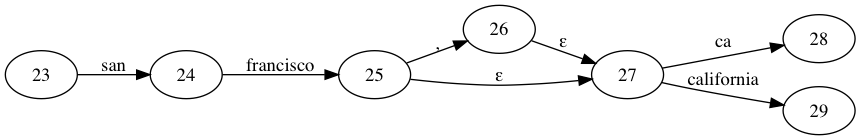

In [51]:
plot(fsa)